In [1]:
# imports

import keras
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import uproot
import awkward as ak

import pandas as pd
import seaborn as sns

2022-11-06 19:16:37.170494: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# take the feature labels out of a root file
# with uproot.open(f"root_files/ntuple_merged_10.root:deepntuplizer/tree;42") as tree:
#     features = ['n_tracks']+[x for x in tree.keys() if x[:5]=='track'] 
#     #labexp = ['fj_isQCD','fj_isH','fj_isBB']
    
# 2 labels: QCD or Hbb. Logical "and" of labels is used.
# features = ['trackBTag_Momentum','trackBTag_PParRatio','trackBTag_PtRatio','trackBTag_Sip2dVal','track_mass','track_pt']
features = ['pfcand_ptrel','pfcand_erel','pfcand_mass','pfcand_deltaR']
labels = ['sample_isQCD',
          'label_H_bb']

nfeatures = len(features)
nlabels = len(labels)

print(f'features: {nfeatures}')
print(f'lables: {nlabels}')

features: 4
lables: 2


In [2]:
# # take the feature labels out of a root file
# with uproot.open(f"root_files/ntuple_merged_10.root:deepntuplizer/tree;42") as tree:
#     features = ['fj_jetNTracks','fj_nSV']+[x for x in tree.keys() if x[:6]=='fj_tau' or x[:8]=='fj_track'] 
#     #labexp = ['fj_isQCD','fj_isH','fj_isBB']
    
# # 2 labels: QCD or Hbb. Logical "and" of labels is used.
# labels = ['sample_isQCD',
#           'label_H_bb']

# nfeatures = len(features)
# nlabels = len(labels)

In [22]:
def reshape(awk_ar,sorter,fet_lngth):
    evt_ar = [[] for i in range(len(awk_ar[0]))]
    srt_idx = np.where(np.array(features)==sorter)[0][0]
    
    for fet in awk_ar:
        for evt_n in range(len(fet)):
            evt_ar[evt_n].append(np.array(fet[evt_n]))
            
    # Making 2D arrays for each event, where each each row of that event's 2D array is now a feature array
    evt_ar2d = []
    
    for evt in evt_ar:
        evt_ar2d.append(np.stack(evt))
        
    # Now sorting each 2d array's columns according to the 'sorter' feature
    evt_ar2d_srtd = []
    
    for evt in evt_ar2d:
        idcs = evt[srt_idx].argsort()[::-1]
        evt_ar2d_srtd.append(evt[:,idcs])
        
    # Now need to standardize feature array per event
    evt_std = []
    npad = 0
    
    for evt in evt_ar2d_srtd:
        if len(evt[0]) > fet_lngth:
            evt_std.append( np.swapaxes(evt[:,:fet_lngth],0,1) )
#             evt_std.append( evt[:,:fet_lngth].flatten() )
        else:
            npad += 1
            padded = np.pad(evt,((0,0),(0,fet_lngth - len(evt[0]))))
            evt_std.append( np.swapaxes(padded,0,1) )
#             evt_std.append( np.pad(evt,((0,0),(0,fet_lngth - len(evt[0])))).flatten() )
            
    print('Number of events padded: {}'.format(npad))
    
    return evt_std
                               

In [19]:
def get_features(file_name,to_sort):
    '''
    Function that extracts our chosen feature and label arrays from a root file
    for the events that are labeled as QCD or Hbb and returns two 2D arrays.
    The first array is the features array and has the shape (nummber_of_events, number_of_features).
    The second array is the labels array ans has the shape (number_of_events, 2)
    '''
    with uproot.open(f"{file_name}:deepntuplizer/tree;42") as tree:
        
        fet_data = []
        lbl_data = []
        
        for fet in features:
            fet_data.append(np.array(tree[fet]))
            
        for lbl in labels:
            lbl_data.append(np.array(tree[lbl]))

        feature_array = reshape(fet_data, to_sort, 5)
        label_array = np.stack(lbl_data,axis=-1)
        #label_array = np.stack([get_labels(tree,i) for i in labels],axis=-1)
        
        feature_array = np.array(feature_array)[label_array.any(1)]
        label_array = label_array[label_array.any(1)]
        
#     return label_array
    return feature_array, label_array

In [3]:
# def get_features(file_name):
#     '''
#     Function that extracts our chosen feature and label arrays from a root file
#     for the events that are labeled as QCD or Hbb and returns two 2D arrays.
#     The first array is the features array and has the shape (nummber_of_events, number_of_features).
#     The second array is the labels array ans has the shape (number_of_events, 2)
#     '''
#     with uproot.open(f"{file_name}:deepntuplizer/tree;42") as tree:

#         feature_array = np.stack(list(tree.arrays(features,library='np').values()),axis=-1)
#         label_array = np.stack(tree.arrays(labels,library='np').values(),axis=-1)
#         #label_array = np.stack([get_labels(tree,i) for i in labels],axis=-1)
        
#         feature_array = feature_array[label_array.any(1)]
#         label_array = label_array[label_array.any(1)]
# #         label_array = label_array[label_array.any(1)][:,1]
        
#     return feature_array, label_array

In [17]:
# This is good way to check which variables have overlap in those that are defined in the CERN Open Data Set


tst_lbls =['pfcand_ptrel','pfcand_erel','pfcand_mass','pfcand_deltaR'] # ['fj_isBB','fj_isH','label_H_bb']

with uproot.open(f"root_files/ntuple_merged_10.root:deepntuplizer/tree;42") as tree:

#     ftrs = np.stack(list(tree.arrays(features,library='np').values()),axis=-1)
#     lbls = np.stack(list(tree.arrays(tst_lbls,library='np').values()),axis=-1)
    #label_array = np.stack([get_labels(tree,i) for i in labels],axis=-1)
    
    lbls = np.array(list(tree.arrays(tst_lbls,library='np').values()))
    
    print(len(lbls))
    
    print(lbls.shape)
    print(lbls[0])
    
    # This tests to see if the even is labelled as both QCD and Hbb
#     print(np.sum(np.sum(label_array,axis=1)==2))
    
#     print(label_array[:,1])
        
#     feature_array = feature_array[label_array[:,0]==1 or lable_array[:,1] == 1]
#     label_array = label_array[label_array[:,0]==1 or lable_array[:,1] == 1]

4
(4, 200000)
[array([0.25022194, 0.14227332, 0.07231812, 0.05621288, 0.04427386,
        0.0302051 , 0.02793544, 0.02728252, 0.02212139, 0.019945  ,
        0.01963409, 0.01807953, 0.01462063, 0.01456623, 0.01363349,
        0.01348581, 0.01328371, 0.01259971, 0.01150374, 0.00991809,
        0.00797489, 0.00769507, 0.00742691, 0.0070305 , 0.00702661,
        0.00643588, 0.00595785, 0.00579851, 0.00552646, 0.00541375,
        0.00519612, 0.00491241, 0.00434499, 0.00419343, 0.00392138,
        0.00387085, 0.00383005, 0.00380673], dtype=float32)
 array([0.25792202, 0.1515218 , 0.08531722, 0.07738646, 0.05595864,
        0.04928399, 0.03928434, 0.01964217, 0.01850921, 0.01674818,
        0.0155167 , 0.01330003, 0.01030752, 0.0097472 , 0.00961173,
        0.00920534, 0.00915608, 0.00772756, 0.00753053, 0.00682858,
        0.00632983, 0.00608661, 0.00586802, 0.00555707, 0.00486128,
        0.00463346, 0.00438716, 0.00421475, 0.00360517, 0.00296634,
        0.0029217 , 0.0027616 , 0.00274159

In [23]:
# load features and labels arrays for a training file

feature_array, label_array = get_features('root_files/ntuple_merged_10.root','pfcand_ptrel')

Number of events padded: 52


In [24]:
feature_array.shape

(187912, 5, 4)

In [77]:
# build a simple neural network in keras

nfeatures = len(feature_array[0])

opt = keras.optimizers.SGD(learning_rate=0.1)
keras_model = keras.Sequential()
keras_model.add(Dense(units=30,activation='relu',input_dim=nfeatures))
keras_model.add(Dense(units=30,activation='relu'))
keras_model.add(Dense(units=nlabels,activation='softmax'))
# keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 30)                930       
                                                                 
 dense_13 (Dense)            (None, 30)                930       
                                                                 
 dense_14 (Dense)            (None, 2)                 62        
                                                                 
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
# fit keras model
keras_model.fit(feature_array, label_array, batch_size=1024, 
                epochs=50, validation_split=0.2)

Epoch 1/50
147/147 [==============================] - 1s 3ms/step - loss: 357847.5625 - accuracy: 0.8533 - val_loss: 0.3879 - val_accuracy: 0.8692
Epoch 2/50
147/147 [==============================] - 0s 3ms/step - loss: 0.3898 - accuracy: 0.8681 - val_loss: 0.3878 - val_accuracy: 0.8692
Epoch 3/50
147/147 [==============================] - 0s 3ms/step - loss: 0.3898 - accuracy: 0.8681 - val_loss: 0.3878 - val_accuracy: 0.8692
Epoch 4/50
147/147 [==============================] - 0s 3ms/step - loss: 0.3898 - accuracy: 0.8681 - val_loss: 0.3878 - val_accuracy: 0.8692
Epoch 5/50
147/147 [==============================] - 0s 2ms/step - loss: 0.3898 - accuracy: 0.8681 - val_loss: 0.3878 - val_accuracy: 0.8692
Epoch 6/50
147/147 [==============================] - 0s 2ms/step - loss: 0.3898 - accuracy: 0.8681 - val_loss: 0.3878 - val_accuracy: 0.8692
Epoch 7/50
147/147 [==============================] - 0s 2ms/step - loss: 0.3898 - accuracy: 0.8681 - val_loss: 0.3878 - val_accuracy: 0.8692
E

In [73]:
history = keras_model.history.history['loss']

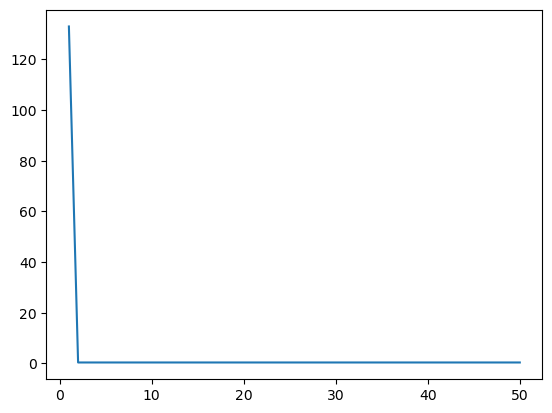

In [74]:
plt.plot(np.arange(1,51), history)

In [79]:
# load features and labels arrays for a testing file
feature_array_test, label_array_test = get_features('root_files/ntuple_merged_0.root')

Number of events padded: 657


In [80]:
# run model inference on test data set
predict_array_test = keras_model.predict(feature_array_test)

# create ROC curve
fpr, tpr, threshold = roc_curve(label_array_test[:,1], predict_array_test[:,1])
    


5876/5876 [==============================] - 5s 773us/step


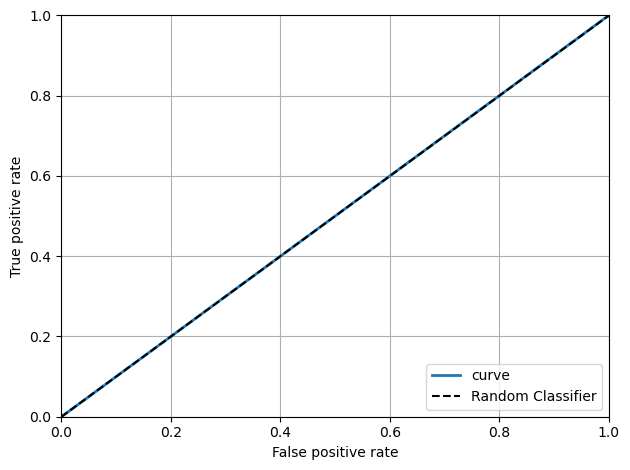

In [81]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label="curve")   #f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('ROC.pdf')
plt.show()

In [63]:
print(len(feature_array))
print(len(label_array))

188007
188007


In [64]:
label_array.shape

(188007, 2)

### Attempting to a Correlation Plot

In [48]:
data = pd.DataFrame(data=feature_array, columns = features)

In [49]:
data.head()

,fj_jetNTracks,fj_nSV,fj_tau0_trackEtaRel_0,fj_tau0_trackEtaRel_1,fj_tau0_trackEtaRel_2,fj_tau1,fj_tau1_trackEtaRel_0,fj_tau1_trackEtaRel_1,fj_tau1_trackEtaRel_2,fj_tau2,...,fj_trackSip2dSigAboveBottom_1,fj_trackSip2dSigAboveCharm_0,fj_trackSipdSig_0,fj_trackSipdSig_0_0,fj_trackSipdSig_0_1,fj_trackSipdSig_1,fj_trackSipdSig_1_0,fj_trackSipdSig_1_1,fj_trackSipdSig_2,fj_trackSipdSig_3
0,12.0,1.0,4.115133,5.333707,7.419932,0.021066,-1.0,-1.0,-1.0,0.017866,...,1.423004,2.222215,1.751387,-1.735610,-24.784317,1.676282,1.751387,1.676282,1.298006,0.640133
1,11.0,0.0,-1.000000,-1.000000,-1.000000,0.126134,-1.0,-1.0,-1.0,0.103946,...,0.711080,1.830022,9.411595,0.838284,-50.000000,2.482426,9.411595,2.482426,2.204618,2.118999
2,10.0,0.0,-1.000000,-1.000000,-1.000000,0.052131,-1.0,-1.0,-1.0,0.017200,...,1.940743,5.326025,18.116814,1.159444,0.492347,3.425295,18.116814,3.425295,1.159444,0.549124
3,6.0,0.0,-1.000000,-1.000000,-1.000000,0.016376,-1.0,-1.0,-1.0,0.010557,...,1.426428,1.935620,1.447032,1.447032,0.793008,0.793008,-1.907130,-3.385496,-0.646736,-1.414297
4,3.0,0.0,-1.000000,-1.000000,-1.000000,0.068397,-1.0,-1.0,-1.0,0.055303,...,-19.000000,0.512057,4.037330,4.037330,0.731296,0.731296,-50.000000,-50.000000,-1.156883,-50.000000


In [50]:
corr = data.corr()

/var/folders/n1/q0yl5j2d5qvcnc78yw8rs7qw0000gn/T/ipykernel_16332/3185258878.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


<AxesSubplot: >

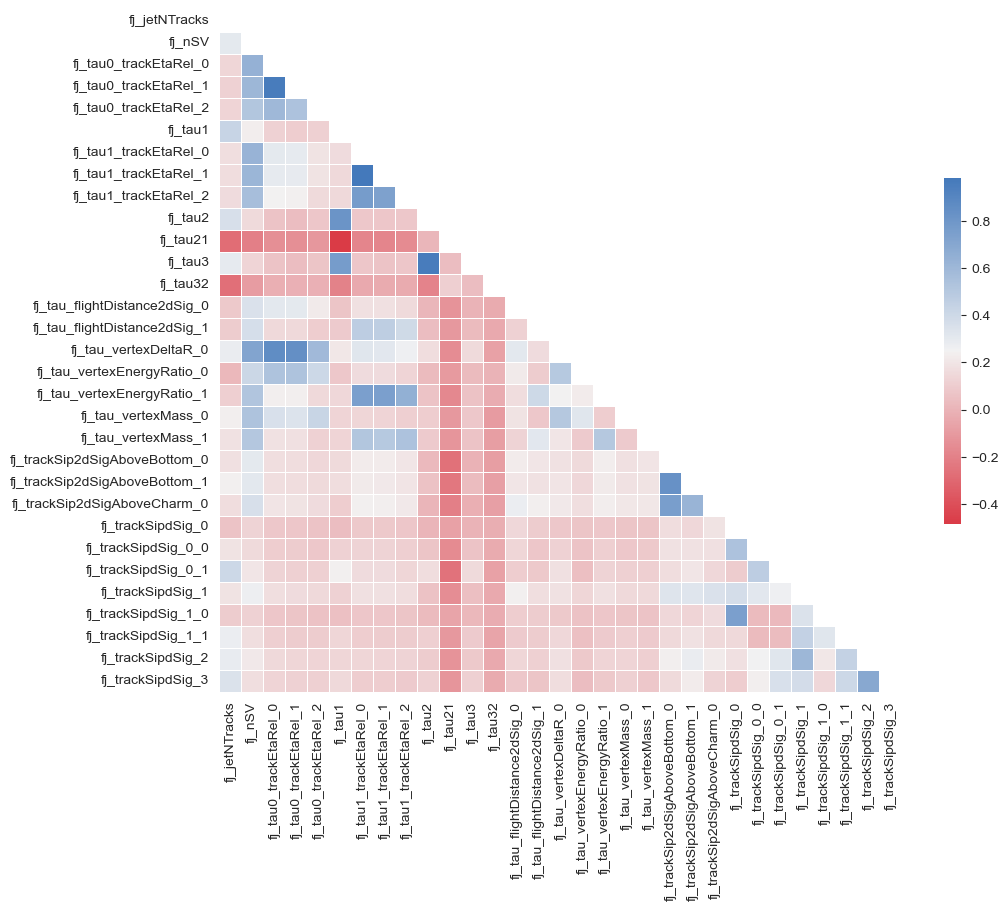

In [51]:
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [62]:
# build a simple neural network in keras

opt = keras.optimizers.SGD(learning_rate=0.6938775510204082)
keras_model = keras.Sequential()
keras_model.add(Dense(units=32,activation='relu',input_dim=nfeatures))
keras_model.add(Dense(units=32,activation='relu'))
keras_model.add(Dense(units=nlabels,activation='softmax'))
# keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                224       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,346
Trainable params: 1,346
Non-trainable params: 0
_________________________________________________________________
None


2022-10-25 12:48:22.087191: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [147]:
# change to sgd
# check learning rate
# figure loss after 10 epochs vs learning rate

In [148]:
# fit keras model
keras_model.fit(feature_array, label_array, batch_size=1024, 
                epochs=10, validation_split=0.2)

Epoch 1/10
147/147 [==============================] - 1s 3ms/step - loss: 2.9239 - accuracy: 0.8578 - val_loss: 0.3959 - val_accuracy: 0.8663
Epoch 2/10
147/147 [==============================] - 0s 2ms/step - loss: 0.3919 - accuracy: 0.8680 - val_loss: 0.3914 - val_accuracy: 0.8663
Epoch 3/10
147/147 [==============================] - 0s 2ms/step - loss: 0.3880 - accuracy: 0.8680 - val_loss: 0.3911 - val_accuracy: 0.8663
Epoch 4/10
147/147 [==============================] - 0s 2ms/step - loss: 0.3877 - accuracy: 0.8680 - val_loss: 0.3910 - val_accuracy: 0.8663
Epoch 5/10
147/147 [==============================] - 0s 2ms/step - loss: 0.3875 - accuracy: 0.8680 - val_loss: 0.3909 - val_accuracy: 0.8663
Epoch 6/10
147/147 [==============================] - 0s 2ms/step - loss: 0.3967 - accuracy: 0.8673 - val_loss: 0.3908 - val_accuracy: 0.8663
Epoch 7/10
147/147 [==============================] - 0s 2ms/step - loss: 0.3875 - accuracy: 0.8680 - val_loss: 0.3913 - val_accuracy: 0.8663
Epoch 

In [97]:
history = keras_model.history.history['loss']

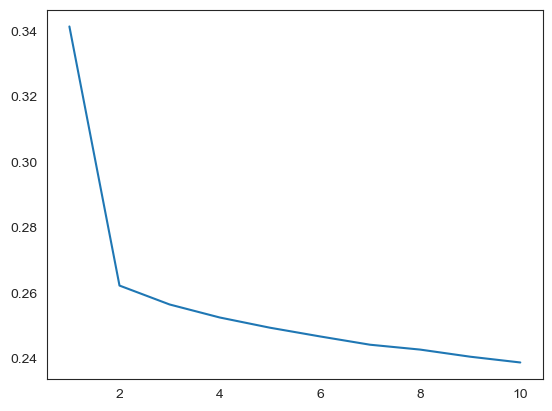

In [98]:
plt.plot(np.arange(1,11), history)

In [69]:
# load features and labels arrays for a testing file
feature_array_test, label_array_test = get_features('root_files/ntuple_merged_0.root')

In [70]:
# run model inference on test data set
predict_array_test = keras_model.predict(feature_array_test)

# create ROC curve
fpr, tpr, threshold = roc_curve(label_array_test[:,1], predict_array_test[:,1])
    


5876/5876 [==============================] - 4s 735us/step


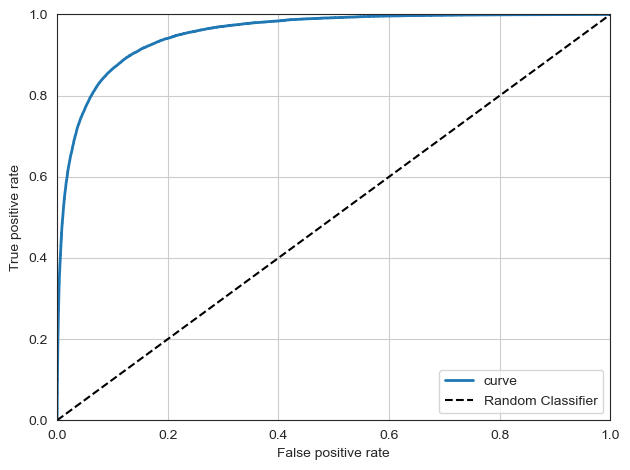

In [71]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label="curve")   #f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('ROC.pdf')
plt.show()

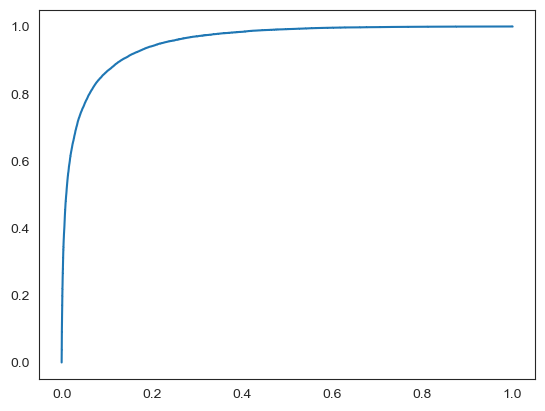

In [72]:
#plt.figure()
plt.plot(fpr, tpr) #, lw=2, label="curve")

In [79]:
keras_model.history

keras.callbacks.History

### Testing Learning Rate

Now using the stochastic gradient descent optimizer, we are going to test the behavior of the loss over various different learning rates.

In [121]:
steps = 50
histories = []

for rate in np.linspace(0,1,steps):
    # Construct model
    opt = keras.optimizers.SGD(learning_rate=rate)
    keras_model = keras.Sequential()
    keras_model.add(Dense(units=32,activation='relu',input_dim=nfeatures))
    keras_model.add(Dense(units=32,activation='relu'))
    keras_model.add(Dense(units=nlabels,activation='softmax'))
    keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    #print(keras_model.summary())
    print('Learning rate: {}'.format(rate))
    
    # fit keras model
    keras_model.fit(feature_array, label_array, batch_size=1024, 
                epochs=10, validation_split=0.2)
    
    histories.append(keras_model.history.history['loss'])
    
    keras.backend.clear_session()

Learning rate: 0.0
Epoch 1/10
147/147 [==============================] - 1s 4ms/step - loss: 1.8851 - accuracy: 0.5016 - val_loss: 1.8544 - val_accuracy: 0.5078
Epoch 2/10
147/147 [==============================] - 0s 3ms/step - loss: 1.8851 - accuracy: 0.5016 - val_loss: 1.8544 - val_accuracy: 0.5078
Epoch 3/10
147/147 [==============================] - 0s 3ms/step - loss: 1.8851 - accuracy: 0.5016 - val_loss: 1.8544 - val_accuracy: 0.5078
Epoch 4/10
147/147 [==============================] - 0s 2ms/step - loss: 1.8851 - accuracy: 0.5016 - val_loss: 1.8544 - val_accuracy: 0.5078
Epoch 5/10
147/147 [==============================] - 0s 2ms/step - loss: 1.8851 - accuracy: 0.5016 - val_loss: 1.8544 - val_accuracy: 0.5078
Epoch 6/10
147/147 [==============================] - 0s 2ms/step - loss: 1.8851 - accuracy: 0.5016 - val_loss: 1.8544 - val_accuracy: 0.5078
Epoch 7/10
147/147 [==============================] - 0s 2ms/step - loss: 1.8851 - accuracy: 0.5016 - val_loss: 1.8544 - val_accu

147/147 [==============================] - 0s 2ms/step - loss: 0.2630 - accuracy: 0.8963 - val_loss: 0.2605 - val_accuracy: 0.8980
Epoch 4/10
147/147 [==============================] - 0s 2ms/step - loss: 0.2598 - accuracy: 0.8967 - val_loss: 0.2565 - val_accuracy: 0.8998
Epoch 5/10
147/147 [==============================] - 0s 2ms/step - loss: 0.2575 - accuracy: 0.8989 - val_loss: 0.2533 - val_accuracy: 0.9014
Epoch 6/10
147/147 [==============================] - 0s 2ms/step - loss: 0.2542 - accuracy: 0.9002 - val_loss: 0.2530 - val_accuracy: 0.9018
Epoch 7/10
147/147 [==============================] - 0s 2ms/step - loss: 0.2525 - accuracy: 0.9006 - val_loss: 0.2486 - val_accuracy: 0.9045
Epoch 8/10
147/147 [==============================] - 0s 2ms/step - loss: 0.2521 - accuracy: 0.9011 - val_loss: 0.2511 - val_accuracy: 0.9033
Epoch 9/10
147/147 [==============================] - 0s 2ms/step - loss: 0.2493 - accuracy: 0.9027 - val_loss: 0.2485 - val_accuracy: 0.9033
Epoch 10/10
147/1

147/147 [==============================] - 0s 2ms/step - loss: 0.2757 - accuracy: 0.8861 - val_loss: 0.2677 - val_accuracy: 0.8929
Epoch 6/10
147/147 [==============================] - 0s 2ms/step - loss: 0.2710 - accuracy: 0.8884 - val_loss: 0.2676 - val_accuracy: 0.8903
Epoch 7/10
147/147 [==============================] - 0s 2ms/step - loss: 0.2716 - accuracy: 0.8858 - val_loss: 0.2642 - val_accuracy: 0.8942
Epoch 8/10
147/147 [==============================] - 0s 2ms/step - loss: 0.2690 - accuracy: 0.8877 - val_loss: 0.2642 - val_accuracy: 0.8917
Epoch 9/10
147/147 [==============================] - 0s 2ms/step - loss: 0.2668 - accuracy: 0.8890 - val_loss: 0.2612 - val_accuracy: 0.8926
Epoch 10/10
147/147 [==============================] - 1s 5ms/step - loss: 0.2717 - accuracy: 0.8806 - val_loss: 0.3096 - val_accuracy: 0.8663
Learning rate: 0.4693877551020408
Epoch 1/10
147/147 [==============================] - 1s 5ms/step - loss: 0.9491 - accuracy: 0.8614 - val_loss: 0.3923 - val

147/147 [==============================] - 0s 2ms/step - loss: 0.3901 - accuracy: 0.8680 - val_loss: 0.3933 - val_accuracy: 0.8663
Epoch 8/10
147/147 [==============================] - 0s 2ms/step - loss: 0.3901 - accuracy: 0.8680 - val_loss: 0.3933 - val_accuracy: 0.8663
Epoch 9/10
147/147 [==============================] - 1s 4ms/step - loss: 0.3901 - accuracy: 0.8680 - val_loss: 0.3934 - val_accuracy: 0.8663
Epoch 10/10
147/147 [==============================] - 1s 3ms/step - loss: 0.3901 - accuracy: 0.8680 - val_loss: 0.3933 - val_accuracy: 0.8663
Learning rate: 0.6938775510204082
Epoch 1/10
147/147 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.8367 - val_loss: nan - val_accuracy: 0.8663
Epoch 2/10
147/147 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8680 - val_loss: nan - val_accuracy: 0.8663
Epoch 3/10
147/147 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8680 - val_loss: nan - val_accuracy: 0.8663


Epoch 10/10
147/147 [==============================] - 0s 2ms/step - loss: 0.3901 - accuracy: 0.8680 - val_loss: 0.3934 - val_accuracy: 0.8663
Learning rate: 0.9183673469387754
Epoch 1/10
147/147 [==============================] - 1s 3ms/step - loss: 8668790466432466944.0000 - accuracy: 0.8505 - val_loss: 0.3935 - val_accuracy: 0.8663
Epoch 2/10
147/147 [==============================] - 0s 2ms/step - loss: 0.3901 - accuracy: 0.8680 - val_loss: 0.3934 - val_accuracy: 0.8663
Epoch 3/10
147/147 [==============================] - 0s 2ms/step - loss: 0.3902 - accuracy: 0.8680 - val_loss: 0.3935 - val_accuracy: 0.8663
Epoch 4/10
147/147 [==============================] - 0s 2ms/step - loss: 0.3902 - accuracy: 0.8680 - val_loss: 0.3934 - val_accuracy: 0.8663
Epoch 5/10
147/147 [==============================] - 0s 2ms/step - loss: 0.3901 - accuracy: 0.8680 - val_loss: 0.3935 - val_accuracy: 0.8663
Epoch 6/10
147/147 [==============================] - 0s 2ms/step - loss: 0.3902 - accuracy: 0.

In [141]:
hist_data = np.array([np.linspace(0,1,steps),np.array(histories)[:,-1]])
fmt_hd = np.stack(hist_data, axis=-1)
cln_fmt_hd = fmt_hd[np.isnan(fmt_hd)[:,1] != True]
print(cln_fmt_hd)

[[0.         1.88509667]
 [0.02040816 0.25573915]
 [0.04081633 0.24652155]
 [0.06122449 0.24346989]
 [0.08163265 0.23876832]
 [0.10204082 0.23821563]
 [0.12244898 0.2435316 ]
 [0.14285714 0.24004026]
 [0.16326531 0.24046883]
 [0.18367347 0.2383289 ]
 [0.20408163 0.25115508]
 [0.2244898  0.24805772]
 [0.24489796 0.23851876]
 [0.26530612 0.24282801]
 [0.28571429 0.24503779]
 [0.30612245 0.26705688]
 [0.32653061 0.24435169]
 [0.34693878 0.24285822]
 [0.36734694 0.26035205]
 [0.3877551  0.26235136]
 [0.40816327 0.39012423]
 [0.42857143 0.27306315]
 [0.44897959 0.27172503]
 [0.46938776 0.31277046]
 [0.48979592 0.39010888]
 [0.51020408 0.30854785]
 [0.53061224 0.37298599]
 [0.55102041 0.38544047]
 [0.57142857 0.32522222]
 [0.59183673 0.39013997]
 [0.6122449  0.39012387]
 [0.63265306 0.39007896]
 [0.65306122 0.30139416]
 [0.67346939 0.39007366]
 [0.71428571 0.39616331]
 [0.73469388 0.39013326]
 [0.75510204 0.39015722]
 [0.7755102  0.390163  ]
 [0.79591837 0.39008069]
 [0.81632653 0.39015552]


Text(0, 0.5, 'Loss')

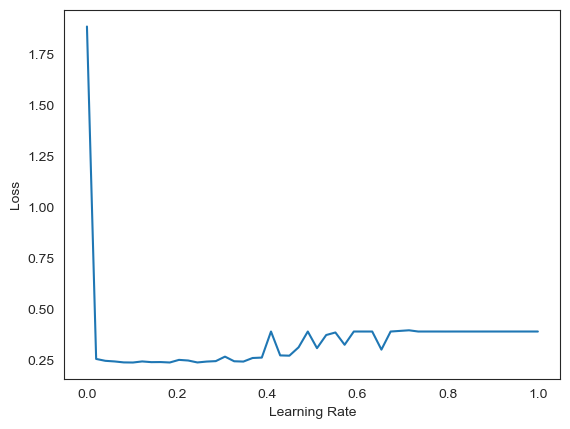

In [150]:
plt.plot(cln_fmt_hd.T[0],cln_fmt_hd.T[1])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')

In [149]:
cln_fmt_hd.T

array([[0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
        0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
        0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
        0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
        0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
        0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
        0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.71428571,
        0.73469388, 0.75510204, 0.7755102 , 0.79591837, 0.81632653,
        0.83673469, 0.87755102, 0.89795918, 0.91836735, 0.93877551,
        0.95918367, 1.        ],
       [1.88509667, 0.25573915, 0.24652155, 0.24346989, 0.23876832,
        0.23821563, 0.2435316 , 0.24004026, 0.24046883, 0.2383289 ,
        0.25115508, 0.24805772, 0.23851876, 0.24282801, 0.24503779,
        0.26705688, 0.24435169, 0.24285822, 0.26035205, 0.26235136,
        0.39012423, 0.27306315, 0.27172503, 0.31277046, 0.39010888,
        0.30854